In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn.metrics import silhouette_score

In [80]:
data = pd.read_csv("house_prices_subset_IrinaCruceru.csv")

In [81]:
data.head()

,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,SalePrice
0,CBlock,TA,TA,No,Rec,922,Unf,0,392,1314,GasA,TA,Y,SBrkr,1314,0,0,1314,145000
1,PConc,Gd,TA,No,Unf,0,Unf,0,799,799,GasA,Gd,Y,SBrkr,799,772,0,1571,178000
2,CBlock,Fa,TA,No,Unf,0,Unf,0,796,796,GasA,Gd,Y,FuseA,796,0,0,796,85000
3,BrkTil,Gd,TA,No,ALQ,569,Unf,0,162,731,GasA,Ex,Y,SBrkr,981,787,0,1768,175000
4,BrkTil,TA,TA,No,LwQ,218,Unf,0,808,1026,GasA,TA,Y,SBrkr,1026,665,0,1691,127000


In [82]:
numeric_features = ['GrLivArea', 'TotalBsmtSF', '1stFlrSF']
categorical_features = ['BsmtQual', 'CentralAir', 'Foundation']

In [83]:
X_num = data[numeric_features]
X_cat = data[categorical_features]

In [84]:
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

In [85]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, drop='first')
X_cat_encoded = encoder.fit_transform(X_cat)

In [86]:
X_scaled = np.hstack([X_num_scaled, X_cat_encoded])

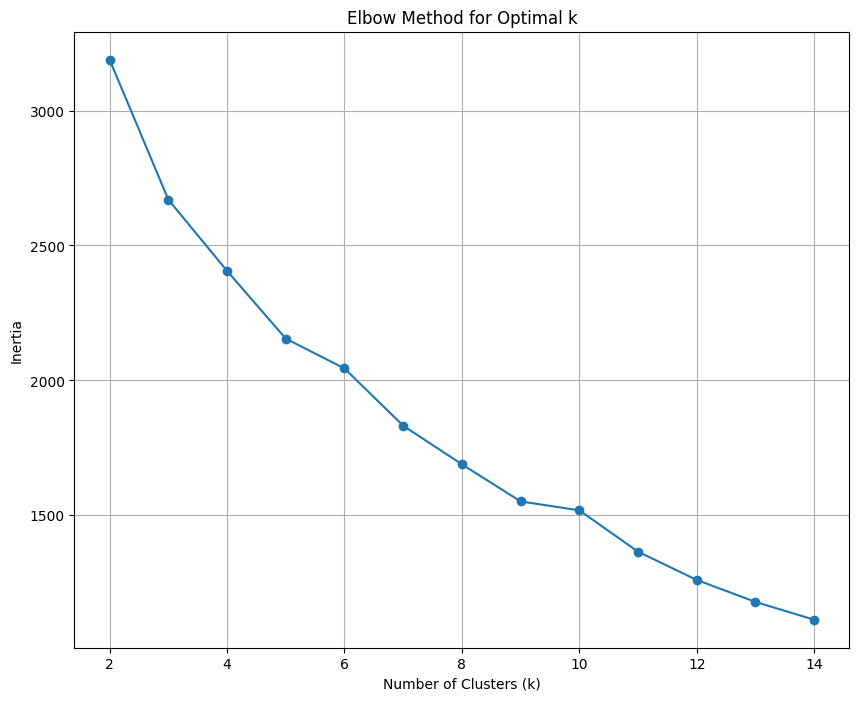

In [87]:
inertia = []
K = range(2, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10,8))
plt.plot(K, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

The inflection (elbow) point is around k = 5 or 6.

In [88]:
kmeans = KMeans(n_clusters=6, random_state=42)
data["Cluster"] = kmeans.fit_predict(X_scaled)

In [89]:
kmeans_summary = data.groupby("Cluster")["SalePrice"].agg(["mean", "median", "std", "count"])
print(kmeans_summary)

                  mean    median            std  count
Cluster                                               
0        270904.716814  262280.0  102515.789893    113
1        155454.590698  154000.0   29435.680038    215
2        260745.649746  240000.0   80781.415150    197
3        189096.763636  185000.0   37705.027767    275
4        118470.182796  118964.0   31268.410389     93
5        121827.349091  123000.0   26665.210376    275


In [90]:
fig = px.scatter(
    data,
    x="GrLivArea",
    y="TotalBsmtSF",
    color="Cluster",
    size="SalePrice",
)
fig.show()

In [91]:
fig = px.scatter(
    data,
    x="GrLivArea",
    y="1stFlrSF",
    color="Cluster",
    size="SalePrice",
)
fig.show()

In [92]:
fig = px.scatter(
    data,
    x="1stFlrSF",
    y="TotalBsmtSF",
    color="Cluster",
    size="SalePrice",
)
fig.show()

In [93]:
fig_box = px.box(
    data,
    x="Cluster",
    y="SalePrice",
    color="Cluster",
    title="SalePrice distribution across clusters"
)
fig_box.show()

The clusters clearly separated into different price ranges despite not having access to the SalePrice variable.
This confirms that the selected size-related features strongly correlate with pricing and that the clustering captured meaningful structure in the housing market.

Cluster 4

* Has the highest median SalePrice
* Contains the most expensive houses (up to ~750k)
* Likely: large living area, high quality homes

Cluster 0
* Also quite high priced but a bit more spread
* Mix of upper-mid and luxury homes
* Possibly homes with large basement AND good living area

Cluster 1

* Classic mid-market homes
* Median ~180k
* Narrow spread, fairly consistent group

Cluster 2 (green)

* Lower-priced homes
* Median ~120k
* Smaller houses or less finished basements


In [94]:
K = range(2, 15)
silhouette_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    print(f"k = {k}, Silhouette Score = {score:.2f}")

k = 2, Silhouette Score = 0.33
k = 3, Silhouette Score = 0.27
k = 4, Silhouette Score = 0.27
k = 5, Silhouette Score = 0.25
k = 6, Silhouette Score = 0.25
k = 7, Silhouette Score = 0.25
k = 8, Silhouette Score = 0.25
k = 9, Silhouette Score = 0.27
k = 10, Silhouette Score = 0.27
k = 11, Silhouette Score = 0.27
k = 12, Silhouette Score = 0.28
k = 13, Silhouette Score = 0.28
k = 14, Silhouette Score = 0.28


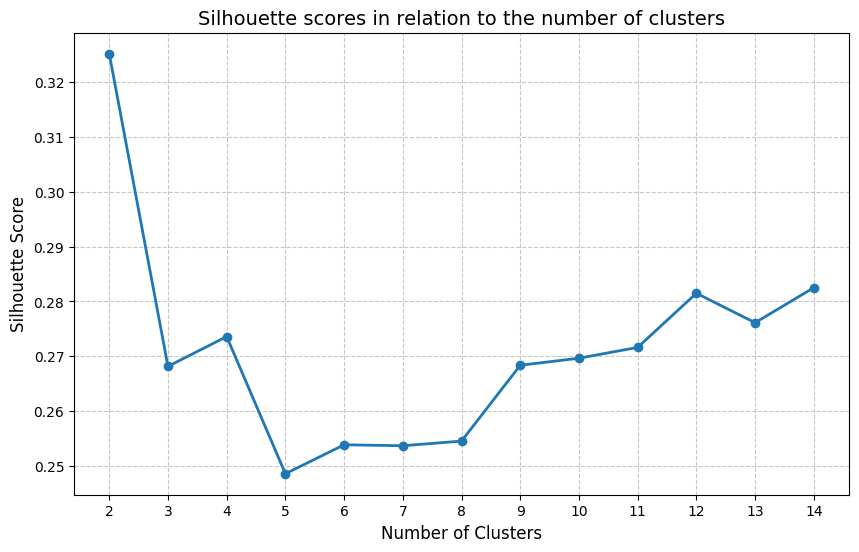

In [95]:
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, marker='o', linestyle='-', linewidth=2)
plt.title("Silhouette scores in relation to the number of clusters", fontsize=14)
plt.xlabel("Number of Clusters", fontsize=12)
plt.ylabel("Silhouette Score", fontsize=12)
plt.xticks(K)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [96]:
optimal_value_k = K[silhouette_scores.index(max(silhouette_scores))]
optimal_value_k

2

k = 2 gives the cleanest separation mathematically but too simple

k = 3 -> worst score

k = 4 to k = 14 -> Silhouette scores are stable and fairly consistent, around 0.38 to 0.41

In [97]:
kmeans_optimal = KMeans(n_clusters=optimal_value_k, random_state=42)
data["Kmeans_with_Sillhoutte"] = kmeans_optimal.fit_predict(X_scaled)

In [98]:
fig = px.scatter(
    data,
    x="GrLivArea",
    y="TotalBsmtSF",
    color="Kmeans_with_Sillhoutte",
    size="SalePrice",
)
fig.show()

In [99]:
fig = px.scatter(
    data,
    x="GrLivArea",
    y="1stFlrSF",
    color="Kmeans_with_Sillhoutte",
    size="SalePrice",
)
fig.show()

In [100]:
fig = px.scatter(
    data,
    x="1stFlrSF",
    y="TotalBsmtSF",
    color="Kmeans_with_Sillhoutte",
    size="SalePrice",
)
fig.show()

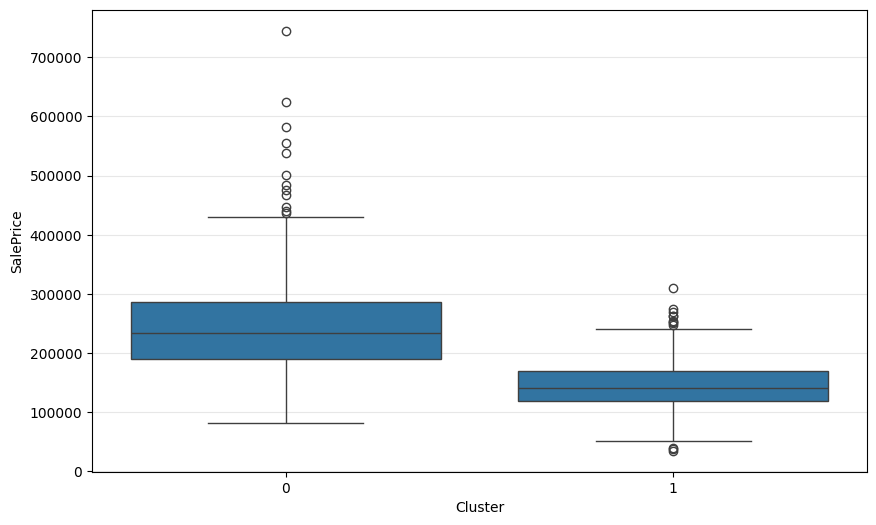

In [101]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=data,
    x="Kmeans_with_Sillhoutte",
    y="SalePrice",
)
plt.xlabel("Cluster")
plt.ylabel("SalePrice")
plt.grid(axis='y', alpha=0.3)
plt.show()

Cluster 0

* Represents higher-priced homes
* Median ≈ $230K–$240K
* Wider spread → more variation
* Many high outliers:

Cluster 1

* Represents lower-priced homes
* Median ≈ $140K–$150K
* Narrower distribution
* Outliers are MUCH lower (some < $50K)

The clustering is fairly well separated but shows some overlap in mid-priced homes.


While k = 2 gives the best silhouette score, the elbow method suggests a slightly larger k might also be reasonable.

This shows that:

Silhouette favors tighter clusters (k=2)

Elbow suggests more nuanced structure (higher k)


In [102]:
data.head()

,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,SalePrice,Cluster,Kmeans_with_Sillhoutte
0,CBlock,TA,TA,No,Rec,922,Unf,0,392,1314,...,TA,Y,SBrkr,1314,0,0,1314,145000,1,1
1,PConc,Gd,TA,No,Unf,0,Unf,0,799,799,...,Gd,Y,SBrkr,799,772,0,1571,178000,3,1
2,CBlock,Fa,TA,No,Unf,0,Unf,0,796,796,...,Gd,Y,FuseA,796,0,0,796,85000,4,1
3,BrkTil,Gd,TA,No,ALQ,569,Unf,0,162,731,...,Ex,Y,SBrkr,981,787,0,1768,175000,3,1
4,BrkTil,TA,TA,No,LwQ,218,Unf,0,808,1026,...,TA,Y,SBrkr,1026,665,0,1691,127000,1,1


In [108]:
data["Avg_SalePrice"] = data.groupby("Cluster")["SalePrice"].transform("mean")

In [112]:
data=data.drop(columns=["SalePrice"])

In [113]:
data.to_csv("subset_classification_cruceru_irina.csv", index=False)